In [2]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import h5py
import os
import math
import copy
matplotlib.use('Agg')
import random
from scipy.interpolate import RegularGridInterpolator
import nibabel as nib


## synth setup

In [ ]:
#widths refer to radius

In [2]:
def calc_distance(xyz0 = [], xyz1 = []):
    delta_OX = (xyz0[0] - xyz1[0])**2
    delta_OY = (xyz0[1] - xyz1[1])**2
    delta_OZ = (xyz0[2] - xyz1[2])**2
    return (delta_OX+delta_OY+delta_OZ)**0.5 

In [3]:
def create_mask(im,center,width):
    dims = np.shape(im)
    mask = np.zeros_like(im)
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                dist_i = calc_distance([i,j,k],center)
                if dist_i<width:
                    mask[i,j,k]=1
    return mask

In [4]:
def create_deformation(im,center,width,polarity=1):
    dims = np.array(np.shape(im))
    mask = np.zeros_like(im)
    
    center = np.array(center)
    xv,yv,zv = np.arange(dims[0]),np.arange(dims[1]),np.arange(dims[2])
    interp_samp = RegularGridInterpolator((xv, yv, zv), im)
    
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                dist_i = calc_distance([i,j,k],center)
                displacement_i = (dist_i/width)**2
                
                if displacement_i < 1.:
                    #within width
                    if polarity > 0:
                        #push outward
                        diff_i = np.array([i,j,k])-center
                        new_coor =  center + diff_i*displacement_i
                        new_coor = np.clip(new_coor,(0,0,0),dims-1)
                        mask[i,j,k]= interp_samp(new_coor)
                        
                    else:
                        #pull inward
                        cur_coor = np.array([i,j,k])
                        diff_i = cur_coor-center
                        new_coor = cur_coor + diff_i*(1-displacement_i)
                        new_coor = np.clip(new_coor,(0,0,0),dims-1)
                        mask[i,j,k]= interp_samp(new_coor)
                else:
                    mask[i,j,k] = im[i,j,k]
    return mask

In [5]:
def create_shift(im,mask,shift):
    dims = np.array(np.shape(im))
    im_apply_shift = copy.deepcopy(im)
 
    pad_val = np.max(np.abs(shift))
    im_pad = np.pad(ima,pad_val,'edge')
    im_pad = np.roll(im_pad,shift,(0,1,2))
     
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                
                if mask[i,j,k] > 0:
                    im_apply_shift[i,j,k] = im_pad[i+pad_val,j+pad_val,k+pad_val]
                
    return im_apply_shift

In [6]:
def create_reflect(im,mask,axis):
    dims = np.array(np.shape(im))
    im_apply_reflect = copy.deepcopy(im)
 
    im_reflect = np.flip(im,axis=axis)
     
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                
                if mask[i,j,k] > 0:
                    im_apply_reflect[i,j,k] = im_reflect[i,j,k]
                
    return im_apply_reflect

In [7]:
def create_interp(im1,im2,center,width,interp):
    dims = np.shape(im1)
    im1_copy = copy.deepcopy(im1)
    im2_copy = copy.deepcopy(im2)
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                dist_i = calc_distance([i,j,k],center)
                if dist_i<width:
                    im1_copy[i,j,k]= interp*im1[i,j,k] + (1-interp)*im2[i,j,k]
                    im2_copy[i,j,k]= (1-interp)*im1[i,j,k] + interp*im2[i,j,k]
    return im1_copy,im2_copy

## uniform additive noise

In [3]:
data_dir = '/path/to/your/data/directory/'
pid_list = os.listdir(data_dir)
out_dir = '.'

In [9]:
for fname in pid_list:

    #load original image
    im = nib.load(os.path.join(data_dir,fname))
    ima = im.get_fdata()

    #create random anomaly
    dims = np.array(np.shape(ima))
    core = dims/2#width of core region
    offset = core/2#offset to center core

    min_width = np.round(0.05*dims[0])
    max_width = np.round(0.10*dims[0])

    sphere_center = []
    sphere_width = []
    for i,_ in enumerate(dims):
        sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
    sphere_width = np.random.randint(min_width,max_width)

    mask_i = create_mask(ima,sphere_center,sphere_width)

    intensity_range = np.max(ima)-np.min(ima)
    sphere_intensity = np.random.uniform(0.2*intensity_range,0.3*intensity_range,size=1)
    if np.random.randint(2):#random sign
        sphere_intensity *= -1

    sphere_add = mask_i*sphere_intensity

    #apply anomaly
    ima_out = ima+sphere_add

    #save
    ima_out_nii = nib.Nifti1Image(ima_out, affine=np.eye(4))
    nib.save(ima_out_nii, os.path.join(out_dir,fname.split('.')[0]+'_out.nii.gz'))

    sphere_add_nii = nib.Nifti1Image(sphere_add, affine=np.eye(4))
    nib.save(sphere_add_nii, os.path.join(out_dir,fname.split('.')[0]+'_out_label.nii.gz'))

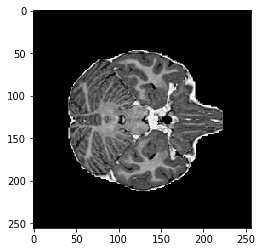

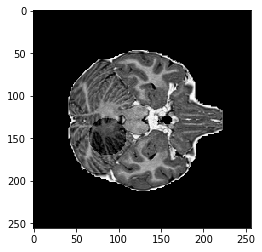

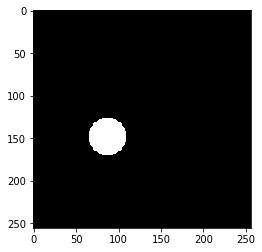

In [15]:
i = 71
plt.imshow(ima[:,:,i],'gray')
plt.figure()
plt.imshow(ima_out[:,:,i],'gray',vmin=np.min(ima[:,:,i]),vmax=np.max(ima[:,:,i]))
plt.figure()
plt.imshow(sphere_add[:,:,i]!=0,'gray')

## additive noise

In [4]:
data_dir = '/path/to/your/data/directory/'
pid_list = os.listdir(data_dir)
out_dir = '.'

In [431]:
for fname in pid_list:

    #load original image
    im = nib.load(os.path.join(data_dir,fname))
    ima = im.get_fdata()

    #create random anomaly
    dims = np.array(np.shape(ima))
    core = dims/2#width of core region
    offset = core/2#offset to center core

    min_width = np.round(0.05*dims[0])
    max_width = np.round(0.10*dims[0])

    sphere_center = []
    sphere_width = []
    for i,_ in enumerate(dims):
        sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
    sphere_width = np.random.randint(min_width,max_width)

    mask_i = create_mask(ima,sphere_center,sphere_width)

    intensity_range = np.max(ima)-np.min(ima)
    sphere_intensity = np.random.uniform(0.05*intensity_range,0.3*intensity_range,size=np.shape(mask_i))
    if np.random.randint(2):#random sign
        sphere_intensity *= -1

    sphere_add = mask_i*sphere_intensity

    #apply anomaly
    ima_out = ima+sphere_add

    #save
    ima_out_nii = nib.Nifti1Image(ima_out, affine=np.eye(4))
    nib.save(ima_out_nii, os.path.join(out_dir,fname.split('.')[0]+'_out.nii.gz'))

    sphere_add_nii = nib.Nifti1Image(sphere_add, affine=np.eye(4))
    nib.save(sphere_add_nii, os.path.join(out_dir,fname.split('.')[0]+'_out_label.nii.gz'))

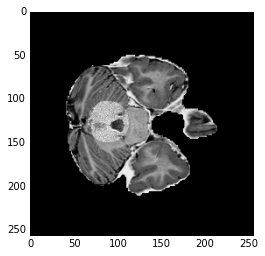

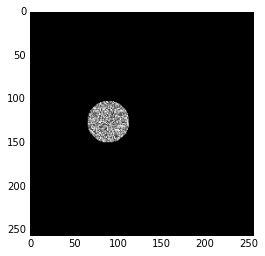

In [437]:
i = 65
plt.imshow(ima_out[:,:,i],'gray')
plt.figure()
plt.imshow(sphere_add[:,:,i],'gray')

## deformation

In [5]:
data_dir = '/path/to/your/data/directory/'
pid_list = os.listdir(data_dir)
out_dir = '.'

In [571]:
for fname in pid_list:

    #load original image
    im = nib.load(os.path.join(data_dir,fname))
    ima = im.get_fdata()

    #create random anomaly
    dims = np.array(np.shape(ima))
    core = dims/2#width of core region
    offset = core/2#offset to center core

    min_width = np.round(0.08*dims[0])
    max_width = np.round(0.13*dims[0])

    sphere_center = []
    sphere_width = []
    for i,_ in enumerate(dims):
        sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
    sphere_width = np.random.randint(min_width,max_width)

    mask_i = create_mask(ima,sphere_center,sphere_width)

    sphere_polarity = 1
    if np.random.randint(2):#random sign
        sphere_polarity *= -1

    #apply anomaly
    ima_out = create_deformation(ima,sphere_center,sphere_width,sphere_polarity)

    #save
    ima_out_nii = nib.Nifti1Image(ima_out, affine=np.eye(4))
    nib.save(ima_out_nii, os.path.join(out_dir,fname.split('.')[0]+'_out.nii.gz'))

    mask_i_nii = nib.Nifti1Image(mask_i, affine=np.eye(4))
    nib.save(mask_i_nii, os.path.join(out_dir,fname.split('.')[0]+'_out_label.nii.gz'))

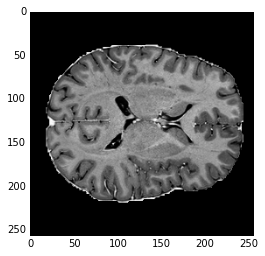

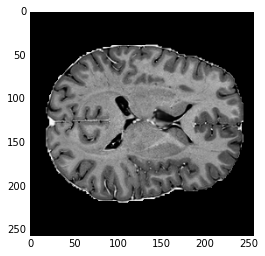

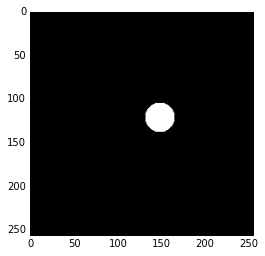

In [579]:
i = 117
plt.imshow(ima[:,:,i],'gray')
plt.figure()
plt.imshow(ima_out[:,:,i],'gray')
plt.figure()
plt.imshow(mask_i[:,:,i],'gray')

## shift volume

In [6]:
data_dir = '/path/to/your/data/directory/'
pid_list = os.listdir(data_dir)
out_dir = '.'

In [22]:
for fname in pid_list:

    #load original image
    im = nib.load(os.path.join(data_dir,fname))
    ima = im.get_fdata()

    #create random anomaly
    dims = np.array(np.shape(ima))
    core = dims/2#width of core region
    offset = core/2#offset to center core

    min_width = np.round(0.08*dims[0])
    max_width = np.round(0.13*dims[0])

    sphere_center = []
    sphere_width = []
    for i,_ in enumerate(dims):
        sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
    sphere_width = np.random.randint(min_width,max_width)

    mask_i = create_mask(ima,sphere_center,sphere_width)

    sphere_shift = np.random.randint(int(0.02*dims[0]),int(0.05*dims[0]),size=3)
    for i in range(3):
        if np.random.randint(2):#random sign
            sphere_shift[i] *= -1

    #apply anomaly
    ima_out = create_shift(ima,mask_i,sphere_shift)

    #save
    ima_out_nii = nib.Nifti1Image(ima_out, affine=np.eye(4))
    nib.save(ima_out_nii, os.path.join(out_dir,fname.split('.')[0]+'_out.nii.gz'))

    mask_i_nii = nib.Nifti1Image(mask_i, affine=np.eye(4))
    nib.save(mask_i_nii, os.path.join(out_dir,fname.split('.')[0]+'_out_label.nii.gz'))

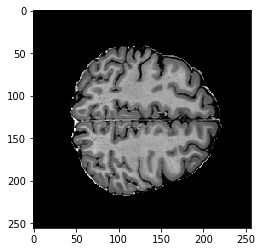

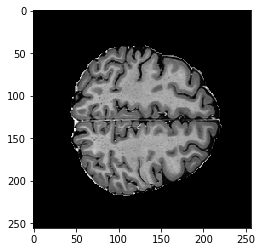

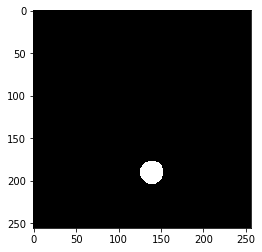

In [30]:
i = 150
plt.imshow(ima[:,:,i],'gray')
plt.figure()
plt.imshow(ima_out[:,:,i],'gray')
plt.figure()
plt.imshow(mask_i[:,:,i],'gray')

## reflect volume

In [3]:
data_dir = '/path/to/your/data/directory/'
pid_list = os.listdir(data_dir)
out_dir = '.'

In [53]:
for fname in pid_list:

    #load original image
    im = nib.load(os.path.join(data_dir,fname))
    ima = im.get_fdata()

    #create random anomaly
    dims = np.array(np.shape(ima))
    core = dims/2#width of core region
    offset = core/2#offset to center core

    min_width = np.round(0.08*dims[0])
    max_width = np.round(0.13*dims[0])

    sphere_center = []
    sphere_width = []
    for i,_ in enumerate(dims):
        sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
    sphere_width = np.random.randint(min_width,max_width)

    mask_i = create_mask(ima,sphere_center,sphere_width)  

    #apply anomaly
    axis=0
    ima_out = create_reflect(ima,mask_i,axis)

    #save
    ima_out_nii = nib.Nifti1Image(ima_out, affine=np.eye(4))
    nib.save(ima_out_nii, os.path.join(out_dir,fname.split('.')[0]+'_out.nii.gz'))

    mask_i_nii = nib.Nifti1Image(mask_i, affine=np.eye(4))
    nib.save(mask_i_nii, os.path.join(out_dir,fname.split('.')[0]+'_out_label.nii.gz'))

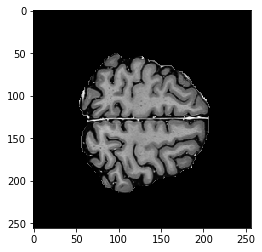

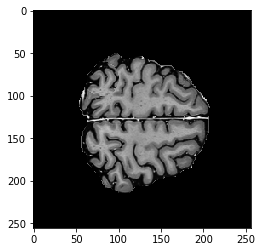

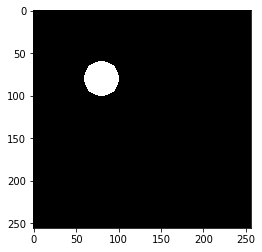

In [70]:
i = 170
plt.imshow(ima[:,:,i],'gray')
plt.figure()
plt.imshow(ima_out[:,:,i],'gray')
plt.figure()
plt.imshow(mask_i[:,:,i],'gray')